# 0. Init

In [1]:
import csv
import os
import json
import argparse
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


from tqdm import tqdm


# 'here_for,'smoke','drink', 'match_age'
union_meta = ['scam','username','age','gender','location','ethnicity','occupation','marital_status','children','religion','sexual_orientation','sex', 'description']

scam_meta = ['email']

tqdm.pandas()

In [2]:
all_profile = pd.read_csv("processed_data.csv")

# 2. tfidf

In [ ]:
scam_sets = all_profile[all_profile['scam'] == 1]['description_stem_set'].dropna()
normal_sets = all_profile[all_profile['scam'] == 0]['description_stem_set'].dropna()
scam_sets.info()

<class 'pandas.core.series.Series'>
Int64Index: 5452 entries, 50918 to 56983
Series name: description_stem_set
Non-Null Count  Dtype 
--------------  ----- 
5452 non-null   object
dtypes: object(1)
memory usage: 85.2+ KB


In [ ]:
scam_sets.head(5)

50918    {'want', 'look', 'hi', 'someon', 'real', 'gee'...
50919    {'read', 'honest', 'god', 'friend', 'care', 'l...
50920    {'goal', 'purpos', 'best', 'minut', 'strong', ...
50921    {'5', 'text', 'friendli', 'jovial', 'woman', '...
50922    {'harmoni', 'quitecar', 'marriag', 'trust', 'w...
Name: description_stem_set, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Convert the sets into space-separated strings
scam_series = scam_sets.apply(' '.join)
normal_series = normal_sets.apply(' '.join)

In [ ]:
# Use TfidfVectorizer to get feature vectors for tokenized descriptions
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x.split())
combined_series = pd.concat([scam_series, normal_series], axis=0)
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_series)

In [ ]:
# Separate back into scam and normal profile tfidf matrices
scam_tfidf_matrix = tfidf_matrix[:len(scam_series)]
normal_tfidf_matrix = tfidf_matrix[len(scam_series):]

In [ ]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(scam_tfidf_matrix, normal_tfidf_matrix)

# Convert similarity to dissimilarity
dissimilarity_matrix = 1 - similarity_matrix

# Get the top 10 dissimilar profiles for each scam profile
top_dissimilar_indices = np.argpartition(dissimilarity_matrix, -10)[:, -10:]

In [ ]:
dissimilarity_matrix

In [ ]:
# Create a DataFrame to store scam profile indices, corresponding normal profile indices, and dissimilarity scores
dissimilarity_df = pd.DataFrame(columns=['Scam Profile Index', 'Normal Profile Index', 'Dissimilarity Score'])

scam_indices = scam_sets.index.tolist()
normal_indices = normal_sets.index.tolist()

data = []

for scam_matrix_idx, norm_indices in enumerate(top_dissimilar_indices):
    scam_idx = scam_indices[scam_matrix_idx]
    for norm_matrix_idx in norm_indices:
        norm_idx = normal_indices[norm_matrix_idx]
        dissimilarity_df = dissimilarity_df.append({
            'Scam Profile Index': scam_idx,
            'Normal Profile Index': norm_idx,
            'Dissimilarity Score': dissimilarity_matrix[scam_matrix_idx, norm_matrix_idx]
        }, ignore_index=True)

# Sort the DataFrame based on dissimilarity scores in descending order
dissimilarity_df.sort_values(by='Dissimilarity Score', ascending=False, inplace=True)

# Reset index
dissimilarity_df.reset_index(drop=True, inplace=True)

# Save to CSV
dissimilarity_df.to_csv('dissimilarity_scores.csv', index=False)

In [ ]:
dissimilarity_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5861 entries, 0 to 5860
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   profile_index  5861 non-null   int64
 1   frequency      5861 non-null   int64
dtypes: int64(2)
memory usage: 91.7 KB


In [ ]:
# Count the frequency of each normal profile that appears in the top 10 dissimilar lists
normal_profile_counts = Counter(dissimilarity_df['Normal Profile Index'])

# Get normal profiles with frequency >= 3
frequent_normal_profile_indices = [int(profile) for profile, count in normal_profile_counts.items() if count >= 3]

# Get details of the frequent normal profiles
# quality_sets = normal_sets[normal_sets.index.isin(frequent_normal_profile_indices)]
quality_sets = normal_sets.loc[frequent_normal_profile_indices]

# Convert the Series to a DataFrame
quality_sets_df = quality_sets.reset_index()
quality_sets_df.columns = ['Original Index', 'Profile Set']

# Save the quality sets DataFrame to CSV
quality_sets_df.to_csv('quality_sets.csv', index=False)

OSError: ignored

In [ ]:
quality_sets_df.info()

In [ ]:
quality_sets_df.head(10)

# Naive & Expert

In [ ]:
# Calculate average dissimilarity score for each scam profile
average_dissimilarity_scores = dissimilarity_df.groupby('Scam Profile Index')['Dissimilarity Score'].mean()

# Show the result
print(average_dissimilarity_scores)


In [ ]:
# Sort the DataFrame based on dissimilarity scores in descending order
sorted_scores = average_dissimilarity_scores.sort_values(ascending=False)

# Determine the number of profiles for 10%
ten_percent_count = int(0.1 * len(sorted_scores))

# Select the highest 10% of profiles for naive_sets
naive_sets = sorted_scores.head(ten_percent_count)

# Select the lowest 10% of profiles for expert_sets
expert_sets = sorted_scores.tail(ten_percent_count)

# Save to CSV
naive_sets.to_csv('naive_sets.csv')
expert_sets.to_csv('expert_sets.csv')


In [ ]:
naive_sets_series = scam_sets.loc[naive_sets.index]
expert_sets_series = scam_sets.loc[expert_sets.index]


In [ ]:
naive_sets_series


In [ ]:
# Step 1: Create {word, count=1} pair for each cell
naive_word_counts = Counter()
for word_set in naive_sets_series:
    word_set = re.sub(r'[^a-zA-Z0-9\s]', '', word_set).split()
    naive_word_counts.update(word_set)

# Step 2: Aggregate all counts at the word level for the entire column
naive_word_counts_aggregated = dict(naive_word_counts)

# Step 3: Get the top 20 words with their counts
top_naive_words = dict(Counter(naive_word_counts_aggregated).most_common(20))

# Creating the bar plot for Naive Sets
plt.figure(figsize=(20, 6))
plt.bar(top_naive_words.keys(), top_naive_words.values(), color='orange')
plt.title('Top Words in Naive Sets and Their Counts')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()


In [ ]:
# Step 1: Create {word, count=1} pair for each cell
expert_word_counts = Counter()
for word_set in expert_sets_series:
    word_set = re.sub(r'[^a-zA-Z0-9\s]', '', word_set).split()
    expert_word_counts.update(word_set)

# Step 2: Aggregate all counts at the word level for the entire column
expert_word_counts_aggregated = dict(expert_word_counts)

# Step 3: Get the top 20 words with their counts
top_expert_words = dict(Counter(expert_word_counts_aggregated).most_common(20))

# Creating the bar plot for Expert Sets
plt.figure(figsize=(20, 6))
plt.bar(top_expert_words.keys(), top_expert_words.values(), color='purple')
plt.title('Top Words in Expert Sets and Their Counts')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()


In [ ]:
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

scam_sets_full = all_profile[all_profile['scam'] == 1][['description']].dropna()

In [ ]:
naive_sets_full = scam_sets_full.loc[naive_sets.index]
expert_sets_full = scam_sets_full.loc[expert_sets.index]

In [ ]:
# extract meta feature
stopwords = set(stopwords.words('english'))

def transform(df, col):
    df['word_count'] = df[col].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df[col].apply(lambda x: len(set(str(x).split())))
    df['stop_word_count'] = df[col].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
    df['mean_word_length'] = df[col].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['char_count'] = df[col].apply(lambda x: len(str(x)))
    return df

In [ ]:
transformed_naive_df = transform(naive_sets_full, 'description')
transformed_naive_df

In [ ]:
transformed_expert_df = transform(expert_sets_full, 'description')
transformed_expert_df

In [ ]:
meta_feature_list = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count']
max_values = {'word_count': 600, 'unique_word_count': 300, 'stop_word_count': 300, 'mean_word_length': 20, 'char_count': 3000}
widths = [20, 10, 10, 1, 100]

from matplotlib.ticker import MaxNLocator

def plot_distribution(df1, df2, feature_list, max_values):
    fig, axes = plt.subplots(nrows=len(feature_list), ncols=2, figsize=(20, 5*len(feature_list)))

    for i, feature in enumerate(feature_list):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        ax1.hist(df1[feature], label='Naive', color='orange', width=widths[i])
        ax1.set_title(f'Naive - {feature}')
        ax1.legend()
        ax1.set_xlim([0, max_values[feature]])
        ax1.set_ylim([0, max(max(np.histogram(df1[feature])[0])+1000, max(np.histogram(df2[feature])[0])+1000)])
        ax1.tick_params(axis='x', labelsize=8)
        ax1.set_ylabel('Document Count')
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

        ax2.hist(df2[feature], label='Expert', color='purple', width=widths[i])
        ax2.set_title(f'Expert - {feature}')
        ax2.legend()
        ax2.set_xlim([0, max_values[feature]])
        ax2.set_ylim([0, max(max(np.histogram(df1[feature])[0])+1000, max(np.histogram(df2[feature])[0])+1000)])
        ax2.tick_params(axis='x', labelsize=8)
        ax2.set_ylabel('Document Count')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot the distribution of meta features
plot_distribution(transformed_naive_df, transformed_expert_df, meta_feature_list, max_values)

In [ ]:
transformed_naive_df[meta_feature_list].describe()

In [ ]:
transformed_expert_df[meta_feature_list].describe()

# 3. other encoder

In [3]:
import nltk
from nltk.tokenize import word_tokenize

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
all_profile = all_profile.dropna(subset = ['description'])

In [5]:
all_profile['tokenized'] = all_profile['description'].apply(word_tokenize)

In [6]:
# Define a function to pad the sequences
def pad_sequence(seq, max_len=100, padding_token='<PAD>'):
    return seq[:max_len] + [padding_token]*(max_len - len(seq))

# Pad the tokenized sequences
all_profile['padded'] = all_profile['tokenized'].apply(lambda x: pad_sequence(x, max_len=100))

In [7]:
from gensim.models import Word2Vec

# w2v_model = Word2Vec(sentences=all_profile['tokenized'], vector_size=100, window=5, min_count=1, workers=4)

# Save the model for future use
# w2v_model.save("word2vec_model.bin")

In [8]:
w2v_model = Word2Vec.load("word2vec_model.bin")

# Function to convert tokens to vectors using Word2Vec
def tokens_to_vectors(tokens, w2v_model):
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    if len(vectors) == 0:
        # If no words in the description are in the Word2Vec vocabulary, return a zero vector
        return np.zeros((100, w2v_model.vector_size))
    else:
        # Otherwise, return the mean of the vectors
        return np.mean(vectors, axis=0)

# Vectorize the padded sequences
all_profile['vectors'] = all_profile['padded'].apply(lambda x: tokens_to_vectors(x, w2v_model))


In [9]:
from scipy.stats import pearsonr

# Separate the scammer and normal profiles
scammer_profiles = all_profile[all_profile['scam'] == 1]
normal_profiles = all_profile[all_profile['scam'] == 0]

# Calculate PCC for each scammer profile against all normal profiles
pcc_results = {}

for scam_index, scam_row in scammer_profiles.iterrows():
    scammer_vector = scam_row['vectors']
    scores = []
    for normal_index, normal_row in normal_profiles.iterrows():
        normal_vector = normal_row['vectors']
        # Ensure both vectors have the same length
        if len(scammer_vector) == len(normal_vector):
            # Calculate the Pearson Correlation Coefficient
            corr, _ = pearsonr(scammer_vector, normal_vector)
            scores.append((normal_index, corr))

    # Sort scores based on the similarity score
    scores.sort(key=lambda x: x[1])
    pcc_results[scam_index] = scores[:10]

# pcc_results now contains the indices of the normal profiles ordered by their PCC similarity to each scammer profile.


In [10]:
# Convert the results to a JSON-compatible format (assuming the indices are JSON-serializable)
pcc_results_json = {str(scam_index): scores for scam_index, scores in pcc_results.items()}

# Save the results to a JSON file
with open('pcc_results.json', 'w') as file:
    json.dump(pcc_results_json, file)

# Trusted Profile

In [ ]:
# To load the results from the JSON file later
# with open('pcc_results.json', 'r') as file:
#    loaded_pcc_results = json.load(file)

In [11]:
# Flatten the list of normal indices from pcc_results
normal_indices = [index for scores in pcc_results.values() for index, _ in scores]

# Count the occurrences of each normal index
index_counts = Counter(normal_indices)

# Filter indices that occur more than twice
trusted_indices = [index for index, count in index_counts.items() if count > 2]

# Create a DataFrame for the trusted profiles
trusted_profile = pd.DataFrame(trusted_indices, columns=['normal_profile_index'])

# Now, trusted_profile contains the indices of normal profiles that have been flagged as similar to scammer profiles more than twice.


In [13]:
# Save the DataFrame to a CSV file
trusted_profile.to_csv('trusted_profile.csv', index=False)

In [15]:
trusted_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   normal_profile_index  158 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB


In [16]:
# Map the trusted indices to the corresponding profiles in all_profile
trusted_profiles_info = all_profile.loc[trusted_profile['normal_profile_index']]

# Save this detailed trusted profile information to a CSV file
trusted_profiles_info.to_csv('trusted_profiles_info.csv', index=False)


In [17]:
trusted_profiles_info.head(10)

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,scam,username,age,gender,location,...,sexual_orientation,sex,description,age_bin,description_set,description_stem,description_stem_set,tokenized,padded,vectors
41806,41806,41806,41806,41807,41807,0,g73,49.0,male,NaN,...,straight,male,6ft 200 lbs brown hair blue eyes kinda muscular,41-50,"{'200', 'lbs', '6ft', 'kinda', 'blue', 'brown'...",6ft 200 lb brown hair blue eye kinda muscular,"{'200', 'kinda', '6ft', 'blue', 'hair', 'brown...","[6ft, 200, lbs, brown, hair, blue, eyes, kinda...","[6ft, 200, lbs, brown, hair, blue, eyes, kinda...","[0.2646183, -0.11624893, 0.40922183, 0.3633533..."
42056,42056,42056,42056,42057,42057,0,seth5575,43.0,male,NaN,...,straight,male,6-2 hazel eyes brown hair tattoo on left hip 228,41-50,"{'hip', 'tattoo', 'left', '228', 'brown', 'hai...",62 hazel eye brown hair tattoo left hip 228,"{'hip', 'tattoo', 'left', '228', 'brown', 'hai...","[6-2, hazel, eyes, brown, hair, tattoo, on, le...","[6-2, hazel, eyes, brown, hair, tattoo, on, le...","[0.32014996, 0.09127371, 0.17957363, 0.2051738..."
23956,23956,23956,23956,23956,23956,0,jaco,50.0,male,NaN,...,straight,male,"blue eyes black hair1,8cm.like hiking music da...",51-60,"{'hiking', 'blue', 'dancing', 'music', 'eyes',...",blue eye black hair18cmlik hike music danc movi,"{'movi', 'danc', 'hike', 'blue', 'eye', 'music...","[blue, eyes, black, hair1,8cm.like, hiking, mu...","[blue, eyes, black, hair1,8cm.like, hiking, mu...","[-0.20303264, 0.5074226, -0.4511016, 1.5733788..."
42167,42167,42167,42167,42168,42168,0,kcmnica,68.0,male,NaN,...,straight,male,"5'9"" 170lbs brown hair and eyes",61-70,"{'5', '170lbs', 'brown', 'hair', 'eyes', '9'}",5 9 170lb brown hair eye,"{'5', '170lb', 'brown', 'hair', 'eye', '9'}","[5, ', 9, '', 170lbs, brown, hair, and, eyes]","[5, ', 9, '', 170lbs, brown, hair, and, eyes, ...","[0.52543426, -0.20159969, 0.39067832, 0.252832..."
43384,43384,43384,43384,43385,43385,0,NaN,26.0,male,NaN,...,straight,male,college football player studying criminal justice,21-30,"{'criminal', 'college', 'football', 'studying'...",colleg footbal player studi crimin justic,"{'justic', 'player', 'studi', 'crimin', 'footb...","[college, football, player, studying, criminal...","[college, football, player, studying, criminal...","[-0.1401991, 0.3329511, -0.0043475456, 0.30685..."
6625,6625,6625,6625,6625,6625,0,pablo138,39.0,male,NaN,...,straight,male,sport\nvegetarian\nmusic\nbook's\ntraveling,31-40,"{'sport', 'music', 'books', 'traveling', 'vege...",sport vegetarian music book travel,"{'travel', 'sport', 'music', 'book', 'vegetari...","[sport, vegetarian, music, book's, traveling]","[sport, vegetarian, music, book's, traveling, ...","[-0.54302204, 0.5801574, -0.530595, 1.4164006,..."
18346,18346,18346,18346,18346,18346,0,logan22,37.0,male,NaN,...,straight,male,"sports,movies,shopping malls.restraunts.campin...",31-40,"{'shopping', 'trails', 'mallsrestrauntscamping...",sport movi shop mallsrestrauntscamp natur trai...,"{'shop', 'movi', 'sport', 'walk', 'natur', 'tr...","[sports, ,, movies, ,, shopping, malls.restrau...","[sports, ,, movies, ,, shopping, malls.restrau...","[-0.66813457, 0.34542465, -0.6980148, 1.195244..."
41875,41875,41875,41875,41876,41876,0,heavyerin,54.0,male,NaN,...,straight,male,m gusta musica rock heavy .punk .toco guitarra,51-60,"{'guitarra', 'gusta', 'toco', 'musica', 'punk'...",gusta musica rock heavi punk toco guitarra,"{'guitarra', 'gusta', 'toco', 'musica', 'heavi...","[m, gusta, musica, rock, heavy, .punk, .toco, ...","[m, gusta, musica, rock, heavy, .punk, .toco, ...","[-0.028196884, 0.019903373, 0.27001536, 0.1315..."
40013,40013,40013,40013,40014,40014,0,NaN,53.0,male,NaN,...,straight,male,country guy like horses fishing camping dancin...,51-60,"{'horses', 'camping', 'like', 'reading', 'danc...",countri guy like hors fish camp danc read,"{'read', 'like', 'camp', 'danc', 'guy', 'count...","[country, guy, like, horses, fishing, camping,...","[country, guy, l

 # Naive and Expert

In [18]:
# Calculate the average PCC score for each scam profile
average_pcc_scores = {}

for scam_index, scores in pcc_results.items():
    # Calculate the mean of the second element in the scores tuples
    average_score = sum(score for _, score in scores) / len(scores)
    average_pcc_scores[scam_index] = average_score

# Now average_pcc_scores contains the average PCC score for each scam profile.


In [24]:
# Sort the scammer profiles by their average PCC score in ascending order
# the PCC now is actual similarity score, we want to descend the dissimilarity score
sorted_by_pcc = sorted(average_pcc_scores.items(), key=lambda item: item[1])

# Calculate the number of profiles in the top and bottom 10%
ten_percent_count = int(len(sorted_by_pcc) * 0.1)

# Get the top 10% as naive set
naive_set = sorted_by_pcc[:ten_percent_count]

# Get the bottom 10% as expert set
expert_set = sorted_by_pcc[-ten_percent_count:]

# Now naive_set and expert_set contains the highest and lowest 10% of scammer profiles based on average PCC score.

# Convert the naive and expert sets to DataFrames
naive_df = pd.DataFrame(naive_set, columns=['scam_profile_index', 'average_pcc_score'])
expert_df = pd.DataFrame(expert_set, columns=['scam_profile_index', 'average_pcc_score'])

# Save to CSV
naive_df.to_csv('naive_set.csv', index=False)
expert_df.to_csv('expert_set.csv', index=False)


In [36]:
naive_sets_df = scammer_profiles.loc[naive_df.scam_profile_index]
expert_sets_df = scammer_profiles.loc[expert_df.scam_profile_index]

In [37]:
expert_sets_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,scam,username,age,gender,location,...,sexual_orientation,sex,description,age_bin,description_set,description_stem,description_stem_set,tokenized,padded,vectors
53961,53961,53961,53961,53979,451,1,NaN,44.0,male,NaN,...,straight,male,"personal description i enjoy, swimming, and re...",41-50,"{'mountain', 'cooking', 'swimming', 'outdoor',...",person descript enjoy swim read walk beach fis...,"{'mountain', 'friend', 'walk', 'swim', 'play',...","[personal, description, i, enjoy, ,, swimming,...","[personal, description, i, enjoy, ,, swimming,...","[-0.80558956, 0.5875845, -0.7541808, 0.8259608..."
54135,54135,54135,54135,54153,670,1,scott5,52.0,male,NaN,...,NaN,male,"i am a person who is ambitious, optimistic, pl...",51-60,"{'honest', 'person', 'sincere', 'playful', 'pa...",person ambiti optimist play hard work devot in...,"{'honest', 'life', 'person', 'trust', 'witti',...","[i, am, a, person, who, is, ambitious, ,, opti...","[i, am, a, person, who, is, ambitious, ,, opti...","[-1.1550654, -0.13971026, -0.25538865, 0.30358..."
55892,55892,55892,55892,55956,2473,1,davemilly,57.0,male,NaN,...,NaN,male,"i am a very simple,honest,sincere,respectful,r...",51-60,"{'thick', 'relocate', 'tribewhat', 'art', 'wor...",simpl honest sincer respect respons care love ...,"{'thick', 'languag', 'pretti', 'tribewhat', 'a...","[i, am, a, very, simple, ,, honest, ,, sincere...","[i, am, a, very, simple, ,, honest, ,, sincere...","[-0.7559558, 0.20768566, -0.3842677, 0.1182070..."
52283,52283,52283,52283,52288,1417,1,wan2mingle,34.0,female,NaN,...,NaN,female,i’m my own lady and i am comfortable with my o...,31-40,"{'ordinary', 'special', 'affectionatei', 'noth...",ladi comfort lifei beauti kind respect wellspo...,"{'special', 'affectionatei', 'noth', 'ordinari...","[i, ’, m, my, own, lady, and, i, am, comfortab...","[i, ’, m, my, own, lady, and, i, am, comfortab...","[-0.6850686, 0.16802129, -0.2531759, -0.054238..."
54182,54182,54182,54182,54200,717,1,gl64,54.0,male,NaN,...,NaN,male,"well, i pride myself in being compassionate, a...",51-60,"{'evolved', 'openness', 'best', 'art', 'consid...",well pride compassion awar evolv least evolv a...,"{'best', 'art', 'fine', 'optimist', 'flaw', 'v...","[well, ,, i, pride, myself, in, being, compass...","[well, ,, i, pride, myself, in, being, compass...","[-0.58094573, 0.35575077, -0.4412093, 0.202413..."


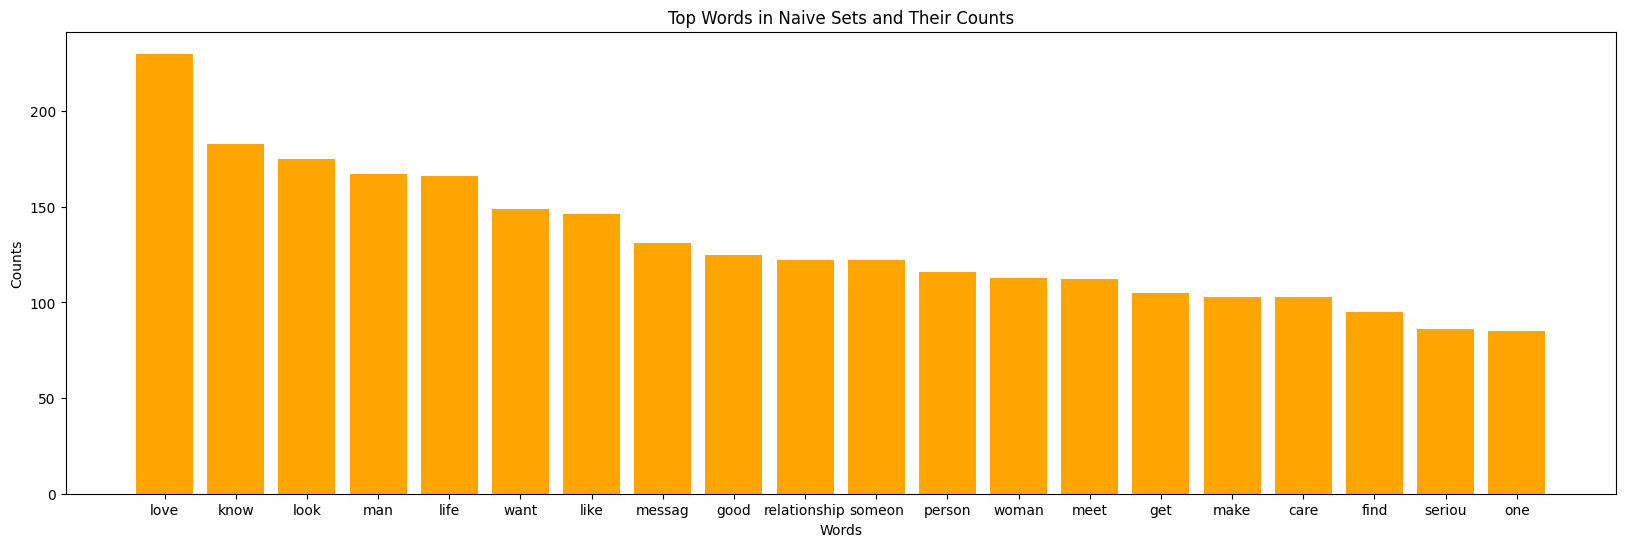

In [38]:
# Step 1: Create {word, count=1} pair for each cell
naive_word_counts = Counter()
for word_set in naive_sets_df.description_stem_set:
    word_set = re.sub(r'[^a-zA-Z0-9\s]', '', word_set).split()
    naive_word_counts.update(word_set)

# Step 2: Aggregate all counts at the word level for the entire column
naive_word_counts_aggregated = dict(naive_word_counts)

# Step 3: Get the top 20 words with their counts
top_naive_words = dict(Counter(naive_word_counts_aggregated).most_common(20))

# Creating the bar plot for Naive Sets
plt.figure(figsize=(20, 6))
plt.bar(top_naive_words.keys(), top_naive_words.values(), color='orange')
plt.title('Top Words in Naive Sets and Their Counts')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

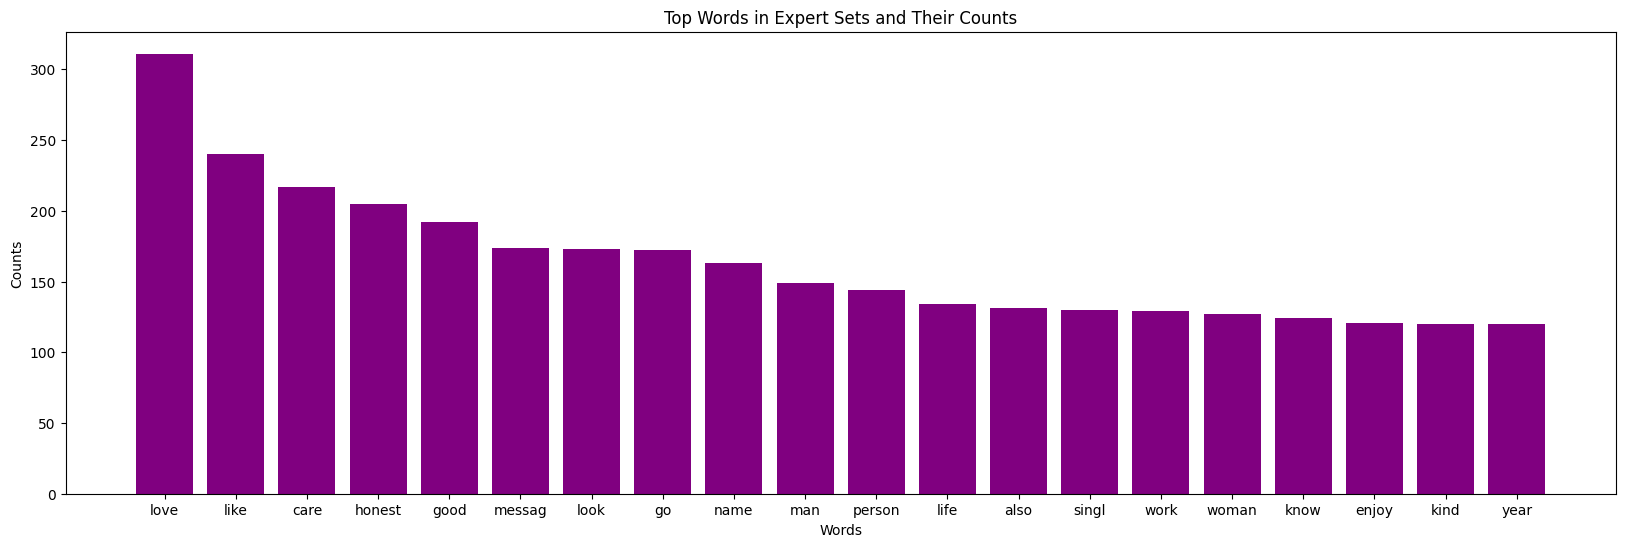

In [39]:
# Step 1: Create {word, count=1} pair for each cell
expert_word_counts = Counter()
for word_set in expert_sets_df.description_stem_set:
    word_set = re.sub(r'[^a-zA-Z0-9\s]', '', word_set).split()
    expert_word_counts.update(word_set)

# Step 2: Aggregate all counts at the word level for the entire column
expert_word_counts_aggregated = dict(expert_word_counts)

# Step 3: Get the top 20 words with their counts
top_expert_words = dict(Counter(expert_word_counts_aggregated).most_common(20))

# Creating the bar plot for Expert Sets
plt.figure(figsize=(20, 6))
plt.bar(top_expert_words.keys(), top_expert_words.values(), color='purple')
plt.title('Top Words in Expert Sets and Their Counts')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()


In [42]:
# extract meta feature
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def transform(df, col):
    df['word_count'] = df[col].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df[col].apply(lambda x: len(set(str(x).split())))
    df['stop_word_count'] = df[col].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
    df['mean_word_length'] = df[col].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['char_count'] = df[col].apply(lambda x: len(str(x)))
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiyir\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [43]:
transformed_naive_df = transform(naive_sets_df, 'description')
transformed_expert_df = transform(expert_sets_df, 'description')

In [45]:
meta_feature_list = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count']
max_values = {'word_count': 600, 'unique_word_count': 300, 'stop_word_count': 300, 'mean_word_length': 20, 'char_count': 3000}
widths = [20, 10, 10, 1, 100]

from matplotlib.ticker import MaxNLocator

def plot_distribution(df1, df2, feature_list, max_values):
    fig, axes = plt.subplots(nrows=len(feature_list), ncols=2, figsize=(20, 5*len(feature_list)))

    for i, feature in enumerate(feature_list):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        ax1.hist(df1[feature], label='Naive', color='orange', width=widths[i])
        ax1.set_title(f'Naive - {feature}')
        ax1.legend()
        ax1.set_xlim([0, max_values[feature]])
        ax1.set_ylim([0, max(max(np.histogram(df1[feature])[0])+1000, max(np.histogram(df2[feature])[0])+1000)])
        ax1.tick_params(axis='x', labelsize=8)
        ax1.set_ylabel('Document Count')
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

        ax2.hist(df2[feature], label='Expert', color='purple', width=widths[i])
        ax2.set_title(f'Expert - {feature}')
        ax2.legend()
        ax2.set_xlim([0, max_values[feature]])
        ax2.set_ylim([0, max(max(np.histogram(df1[feature])[0])+1000, max(np.histogram(df2[feature])[0])+1000)])
        ax2.tick_params(axis='x', labelsize=8)
        ax2.set_ylabel('Document Count')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

    plt.tight_layout()
    plt.show()

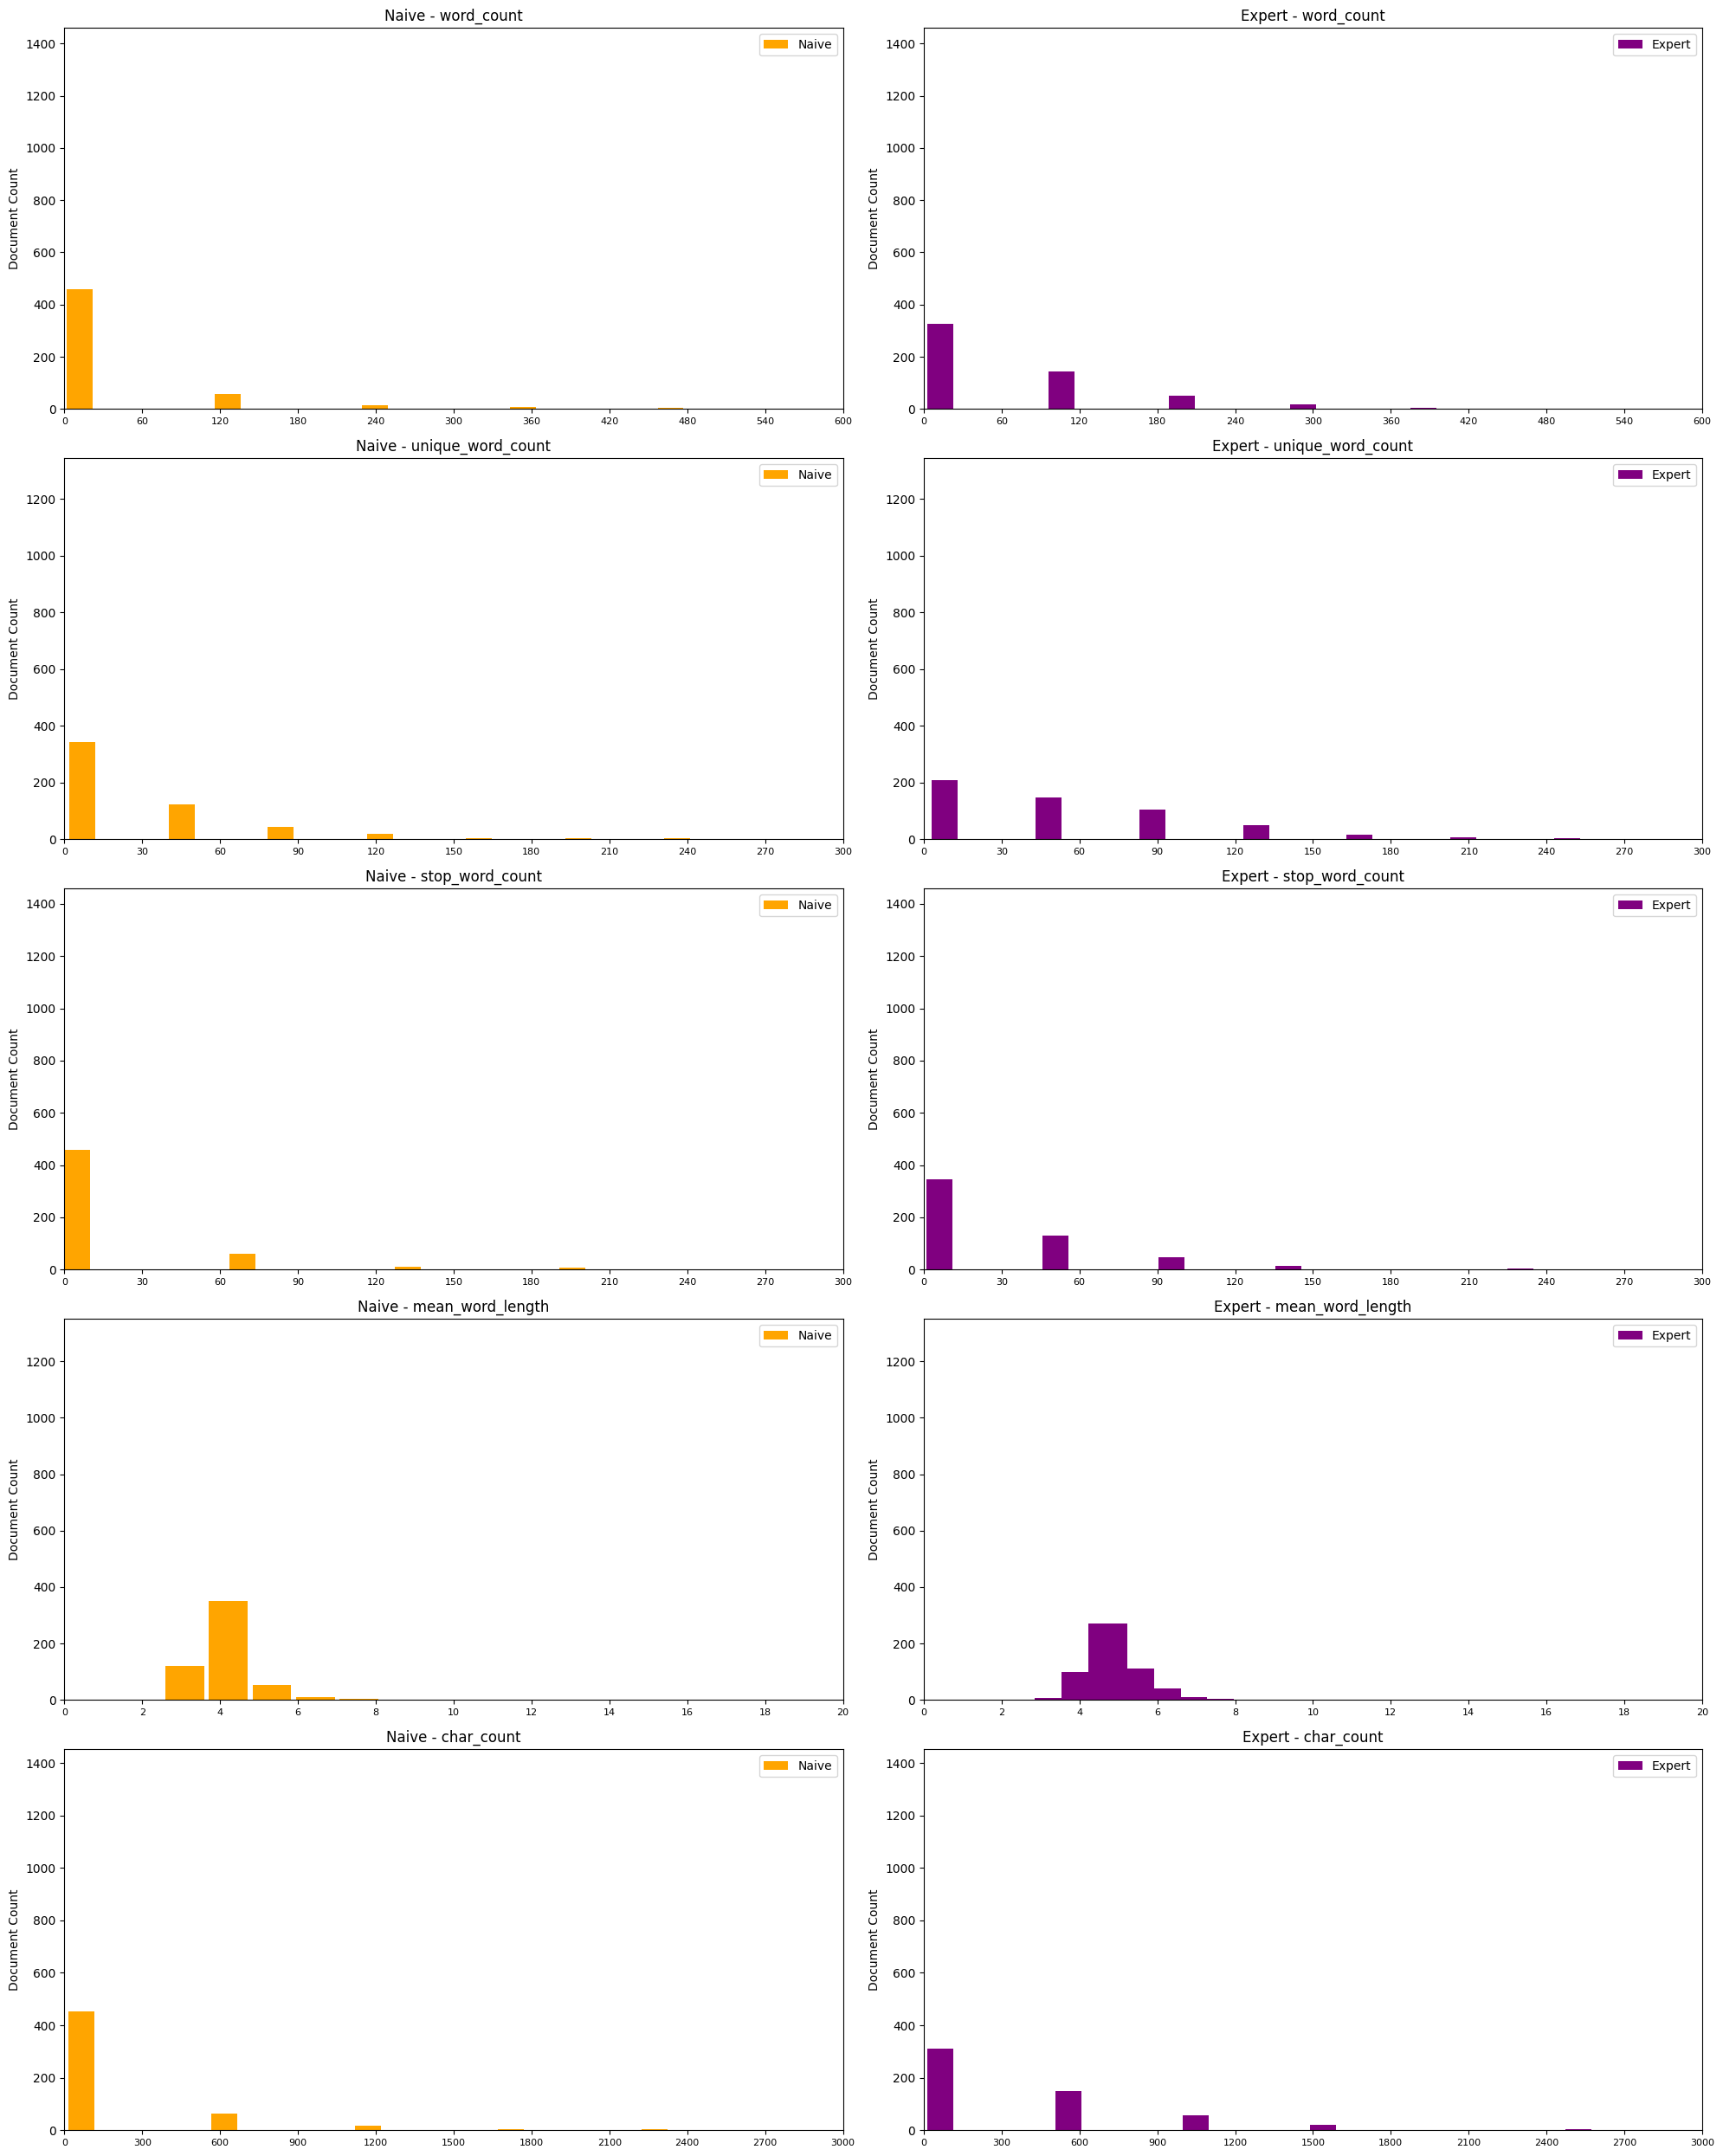

In [46]:
# Plot the distribution of meta features
plot_distribution(transformed_naive_df, transformed_expert_df, meta_feature_list, max_values)

In [47]:
transformed_naive_df[meta_feature_list].describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count
count,545.000000,545.000000,545.000000,545.000000,545.000000
mean,69.091743,43.130275,36.688073,4.193805,351.082569
std,109.316135,46.362894,58.965016,0.934014,553.123127
min,2.000000,2.000000,0.000000,2.600000,14.000000
25%,16.000000,14.000000,8.000000,3.769231,81.000000
50%,34.000000,28.000000,18.000000,4.043478,178.000000
75%,82.000000,55.000000,45.000000,4.391304,406.000000
max,1140.000000,384.000000,636.000000,13.750000,5538.000000


In [48]:
transformed_expert_df[meta_feature_list].describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count
count,545.000000,545.000000,545.000000,545.000000,545.000000
mean,102.381651,70.115596,45.080734,4.738445,574.260550
std,98.649489,53.661413,47.814986,0.708434,536.266521
min,3.000000,3.000000,1.000000,2.857143,14.000000
25%,35.000000,30.000000,13.000000,4.318182,202.000000
50%,73.000000,56.000000,28.000000,4.622951,426.000000
75%,146.000000,99.000000,64.000000,5.063830,793.000000
max,934.000000,403.000000,449.000000,9.714286,4934.000000
